# Принятие решений в бизнесе на основе данных

1. В нашем распоряжении список из девяти гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Требуется выполнить приоритизацию гипотез.
2.  Был проведен A/B-тест и получены результаты, которые описаны в файлах orders.csv и visitors.csv. Требуется провести анализ полученных данных.

### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment', None)
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="darkgrid")

**Рассмотрим таблицу с гипотезами:**

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

Пропусков нет. Переименовали столбцы для удобства.

**Рассмотрим таблицу orders:**

In [6]:
display(orders)
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Переименнуем столбцы и изменим формат в столбце date:

In [7]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Проверим количество пользователей в разных группах, выразим в процентах от общего количества:

In [8]:
round(orders.groupby('group').agg({'visitor_id':'nunique'})/orders['visitor_id'].nunique()*100, 1)

,visitor_id
group,
A,48.8
B,56.8


Из предыдущей проверки видим, что 5% пользователей попали в обе группы. Найдем этих пользователей:

In [9]:
visitor_both_group = np.intersect1d(orders.query('group == "A"')['visitor_id'], orders.query(
'group == "B"')['visitor_id'], assume_unique = False)
print('Количество пользователей, попавших в обе группы:', len(visitor_both_group))

Количество пользователей, попавших в обе группы: 58


Удалим данные пользоватей, которые попали в обе группы, из таблицы orders:

In [10]:
orders = orders.query('visitor_id not in @visitor_both_group').reset_index(drop=True)
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1011,3592955527,608641596,2019-08-14,16490,B
1012,2662137336,3733762160,2019-08-14,6490,B
1013,2203539145,370388673,2019-08-14,3190,A
1014,1807773912,573423106,2019-08-14,10550,A


In [11]:
round(orders.groupby('group').agg({'visitor_id':'nunique'})/orders['visitor_id'].nunique()*100, 1)

,visitor_id
group,
A,45.7
B,54.3


Количество пользователей в группе A - 45,7% от общего количества, в группе B - 54.3%.

**Рассмотрим таблицу visitors:**

In [12]:
display(visitors)
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Требуется изменить формат в столбце date:

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


**Вывод:**

В ходе предобработки данных выяснилось: 
- инструмент «деления» трафика работает ошибочно, в таблице orders нашлись пользователи, которые находились и в группе A, и в группе B;
- количество пользователей в группах различается более, чем на 8%.

Будем иметь это ввиду при анализе результатов. 

### Приоритизация гипотез

Чтобы сыкономить ресурсы и максимизировать ожидаемое улучшение ключевых метрик, приоритизацию сформулированных гипотез. Воспользуемся двумя методами ICE и его модификацией RICE. 

Фреймворк ICE состоит из трёх компонент:
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
- Efforts — сколько стоит протестировать эту гипотезу. 

У метода ICE есть модификация RICE. Добавляется еще одна компонента:
- Reach — скольких пользователей затронет изменение, которое вы хотите внести.


Каждый параметр фреймворков ICE и RICE в нашем случае оценены в удобных шкале от 0 до 10 .

In [14]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Рассчитаем коэфицент ICE:**
$$ICE=\frac{impact*confidence}{efforts}$$

In [15]:
hypothesis['ICE']=round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 1)

In [16]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


**Рассчитаем коэфицент RICE:**
$$ICE=\frac{reach*impact*confidence}{efforts}$$

In [17]:
hypothesis['RICE']=round((hypothesis['impact']*hypothesis['confidence']*hypothesis['reach'])/hypothesis['efforts'], 1)

In [18]:
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Создадим точечную диаграмму, чтобы сопоставить метрики для каждой гипотезы и сравнить их:**

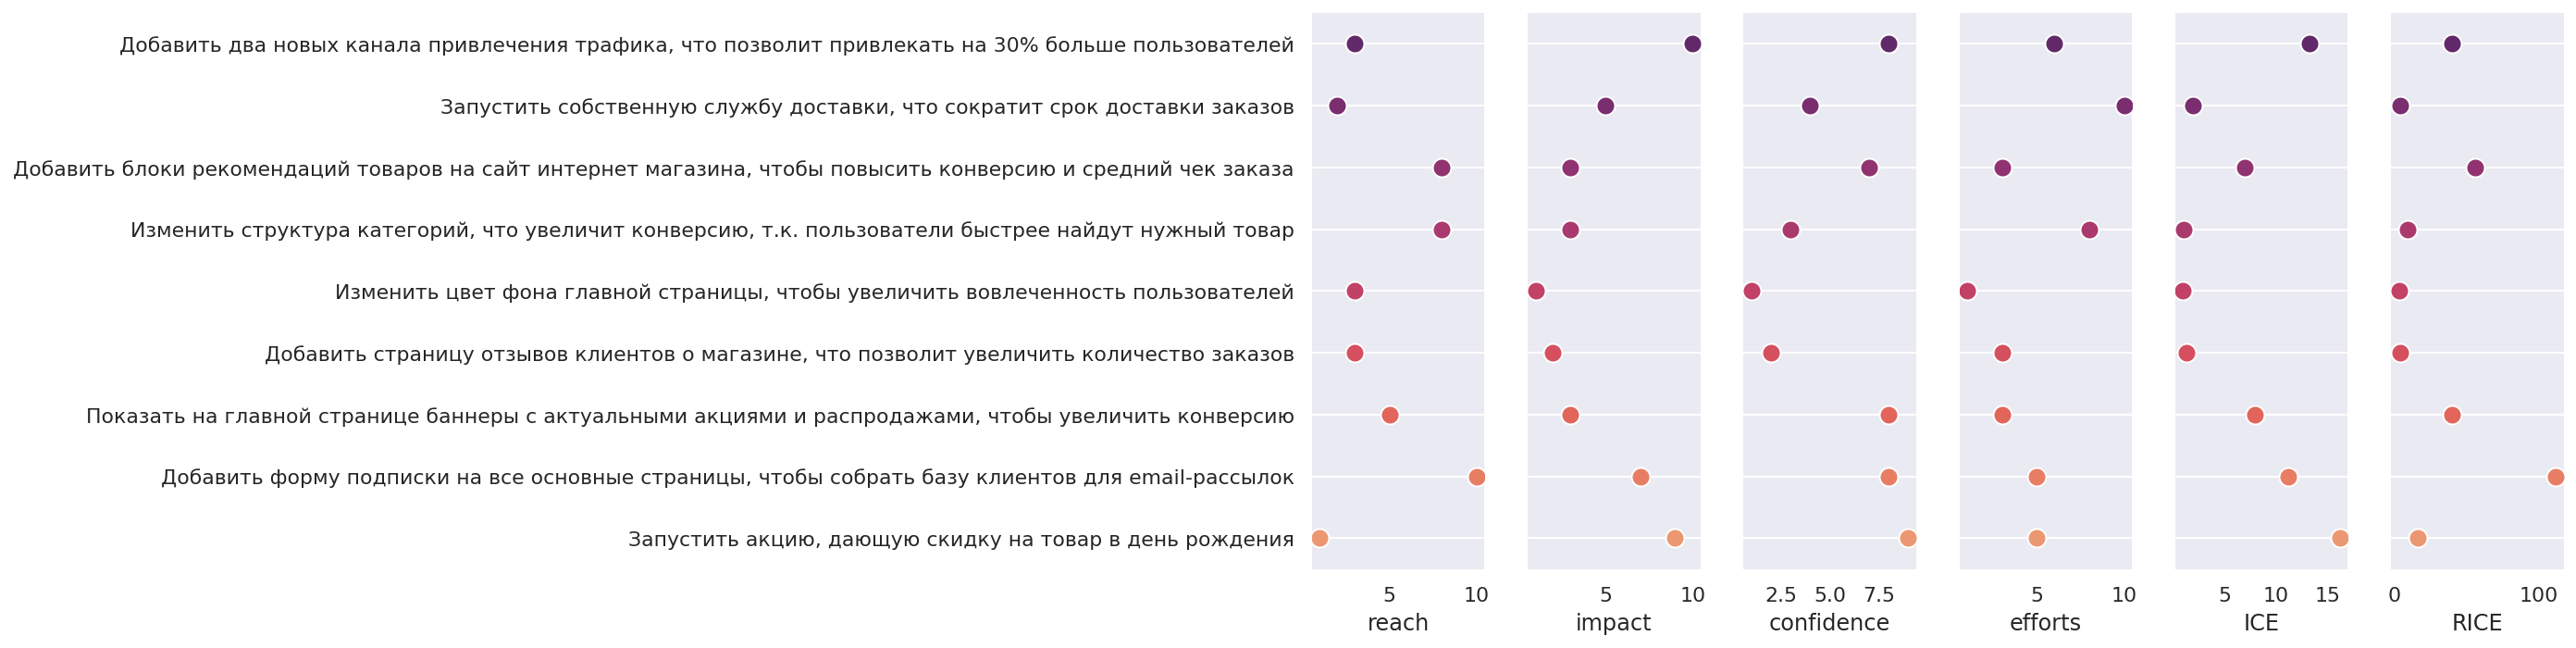

In [19]:
g = sns.PairGrid(hypothesis,
                 x_vars=hypothesis.columns[1:7], y_vars=["hypothesis"],
                 height=5, aspect=.35)

g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

g.set(ylabel="")

for ax in g.axes.flat:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

**Вывод:**

Методы показали разные приоритеты:
- по ICE лидер гипотеза №8 "Запустить акцию, дающую скидку на товар в день рождения"
- по RICE лидер гипотеза №7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	"

Это связано с тем, что RICE учитывает "охват" - скольких пользователей затронет изменение. У гипотезы №7 "охват" самый большой, мы оценили его в 10 баллов. А гипотеза №8 (лидер по ICE) опустилась на пятую строчку по RICE. Однако это не значит, что ипотезе №8 не стоит уделить внимание. Да, охват мы оценили в 1 бал - она влияет на небольшой процент пользователей, но это пользователи у которых день рождения, соответственно они готовы покупать и вклад будет большим.

Таким образом обе гипотезы №7 и №8 заслуживают внимания.

### Анализ A/B-теста

**Построим график кумулятивной выручки по группам:**

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


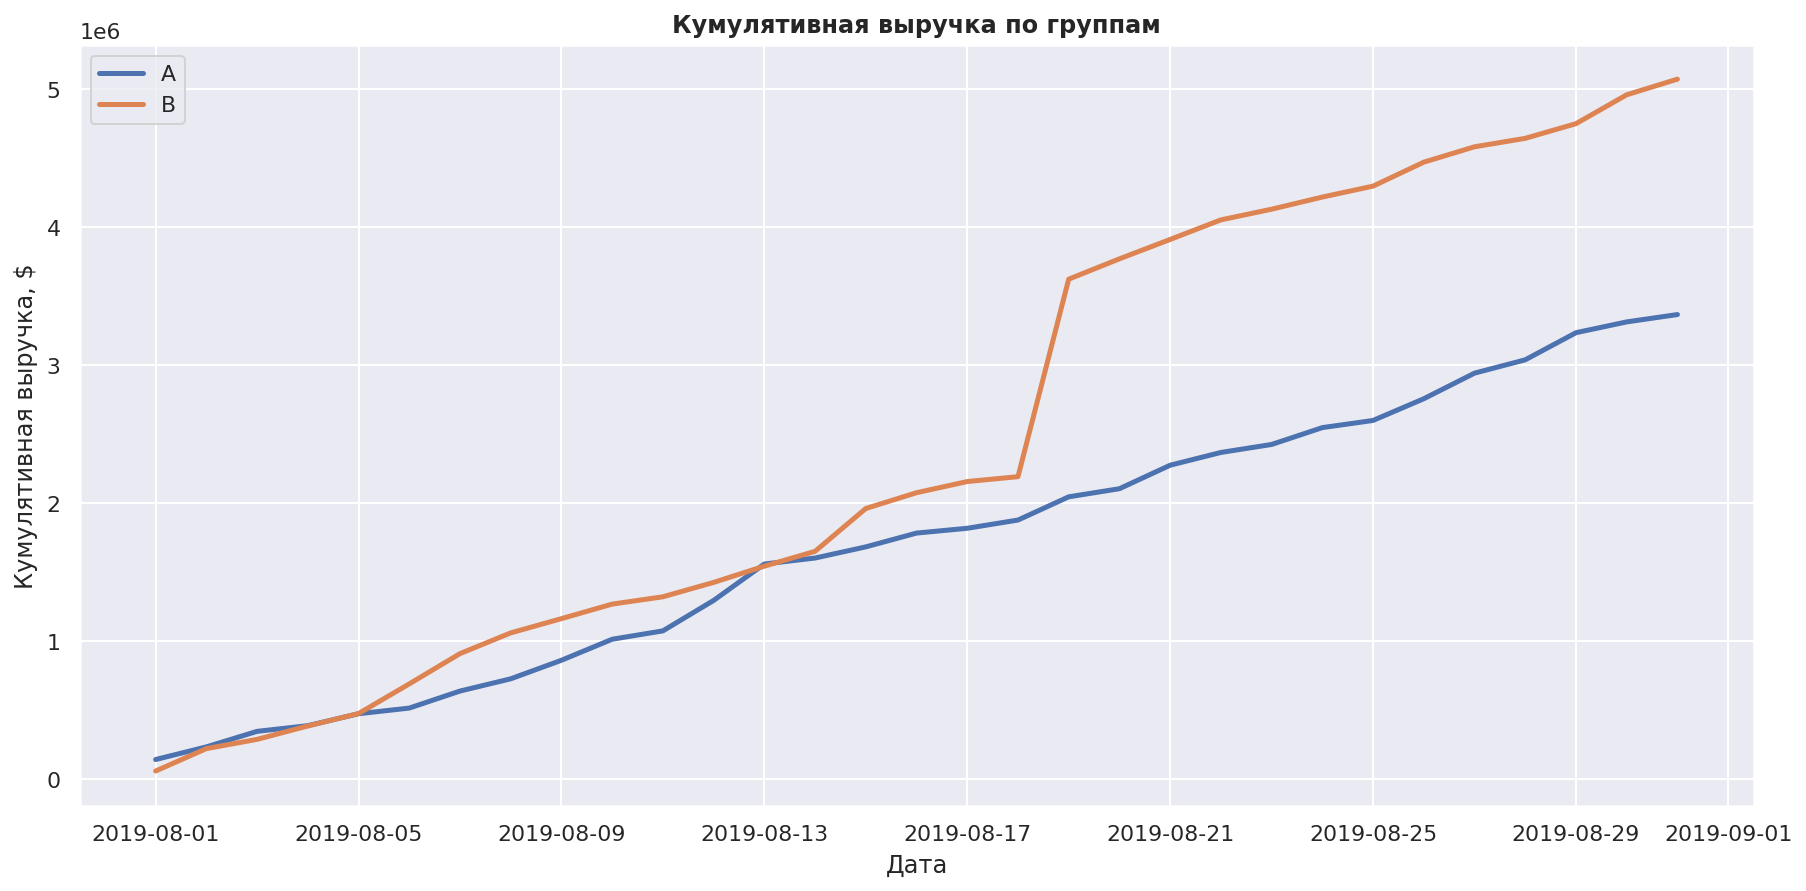

In [20]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data) 


# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим графики

plt.figure(figsize=(15, 7))
# Строим график выручки группы А
sns.lineplot(data=cumulative_revenueA, x='date', y='revenue', label='A', linewidth=2.5)

# Строим график выручки группы B
sns.lineplot(data=cumulative_revenueB, x='date', y='revenue', label='B', linewidth=2.5)
plt.ylabel('Кумулятивная выручка, $')
plt.xlabel('Дата')
plt.title('Кумулятивная выручка по группам', fontweight="bold")
plt.show() 

Выручка увеличивается в течение всего теста. Практически на всем протяжении теста выручка в группе B выше. Однако графики выручки в нескольких точках резко растут, особенно это выражено для группы B. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

**Построим график кумулятивного среднего чека по группам:**

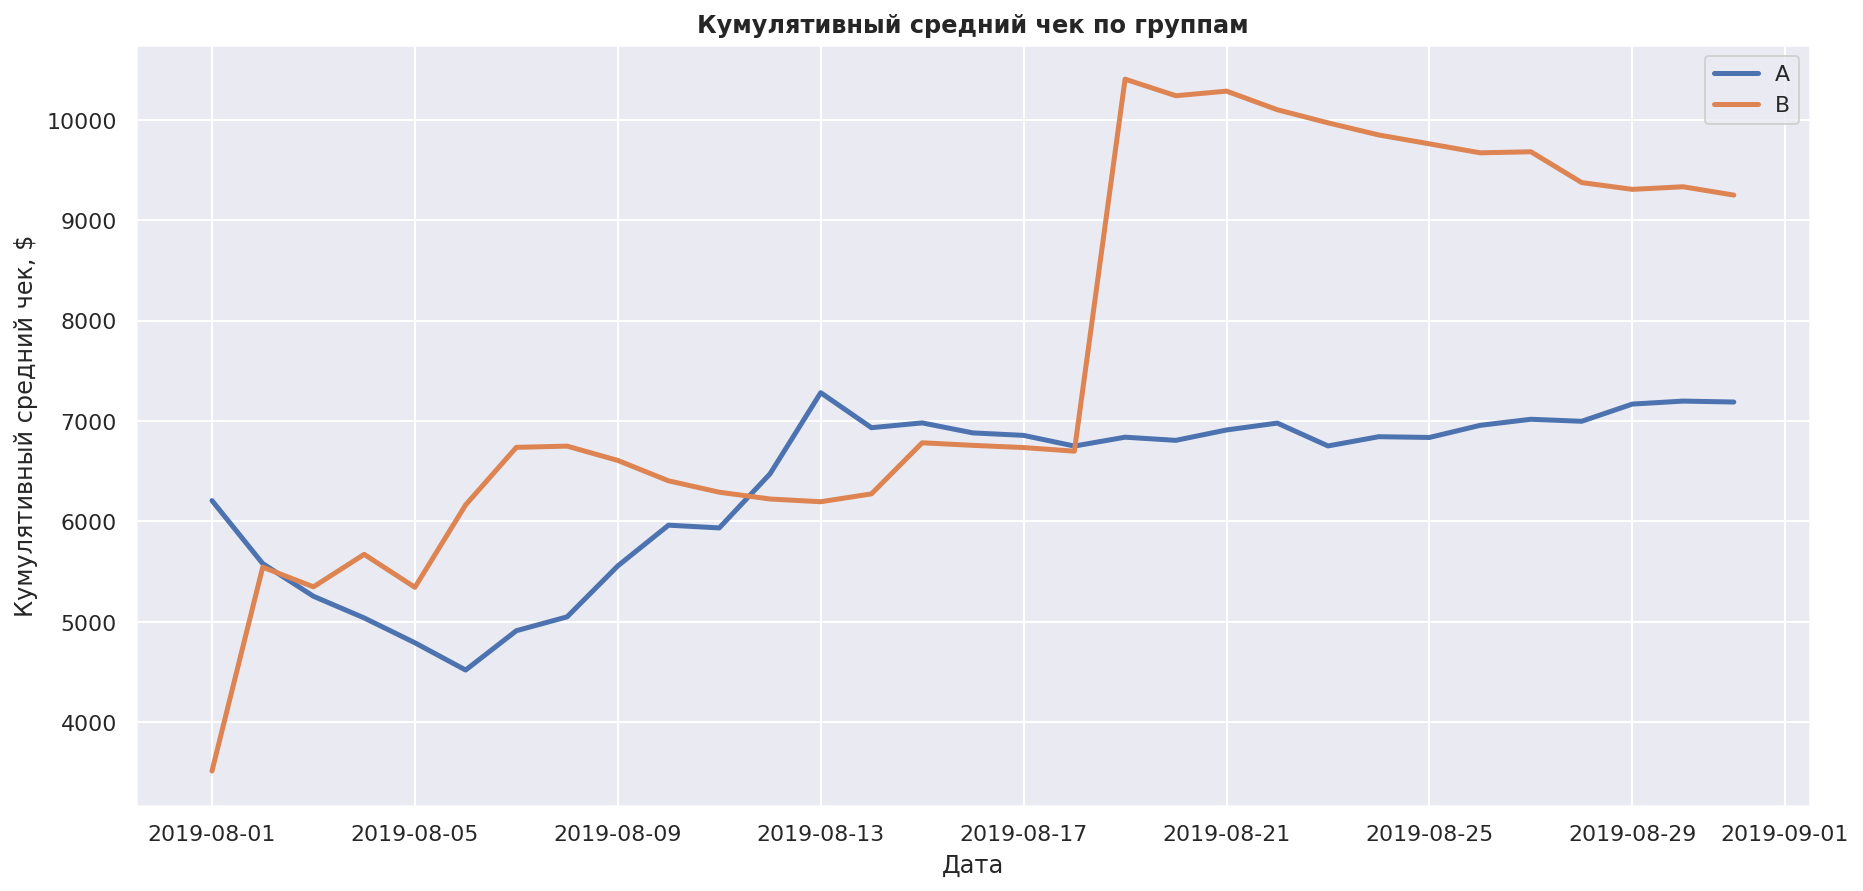

In [21]:
plt.figure(figsize=(15, 7))
# Строим график ср. чека группы А
sns.lineplot(data=cumulative_revenueA, x='date', y=cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label='A', linewidth=2.5)

# Строим график ср. чека группы B
sns.lineplot(data=cumulative_revenueB, x='date', y=cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label='B', linewidth=2.5)
plt.ylabel('Кумулятивный средний чек, $')
plt.xlabel('Дата')
plt.title('Кумулятивный средний чек по группам', fontweight="bold")
plt.show() 

Средний чек по группе A практически установился ближе к концу теста. По графику среднего чека группы B подтверждаем сильный всплеск в середине теста (возможно мы наблюдаем крупный заказ), который мешает установиться среднему чеку к концу теста, средний чек к концу теста продолжает падение.

**Построим график относительного изменения кумулятивного среднего чека группы B к группе A:**

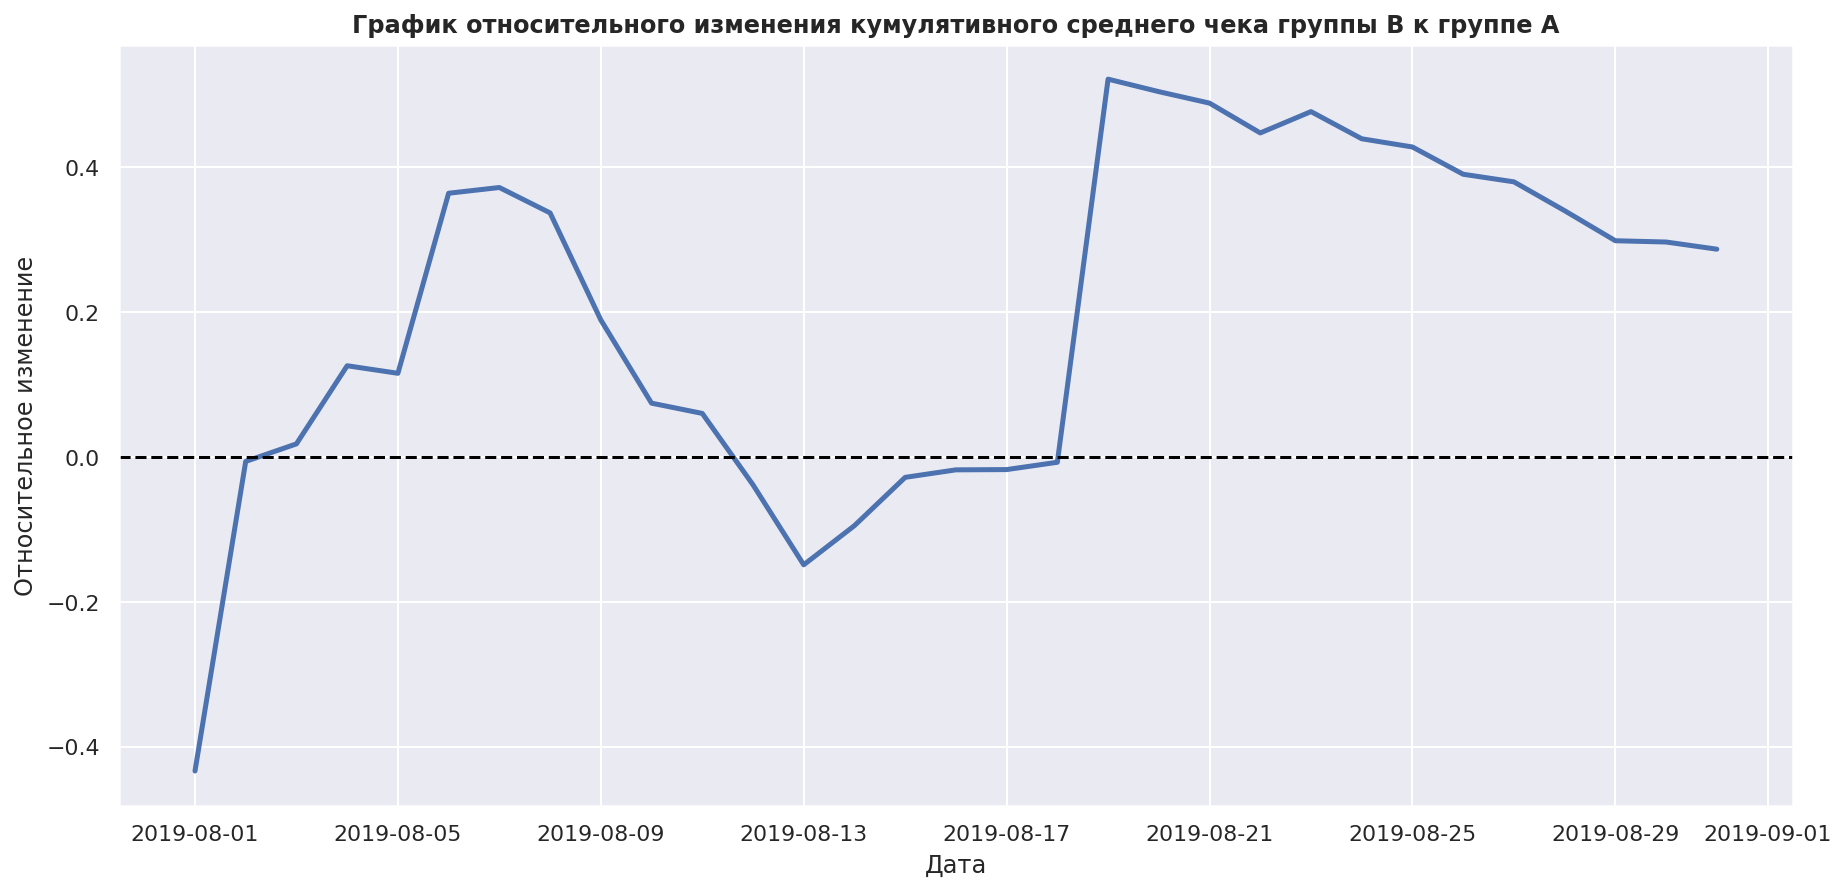

In [22]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenueA.merge(cumulative_revenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 7))
sns.lineplot(data=merged_cumulative_revenue, x='date',
            y=(merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1,
            linewidth=2.5)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.ylabel('Относительное изменение')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontweight="bold")
plt.show() 

График сильно "скачет", сказываются крупные заказы и выбросы.

**Построим график кумулятивного среднего количества заказов на посетителя по группам:**

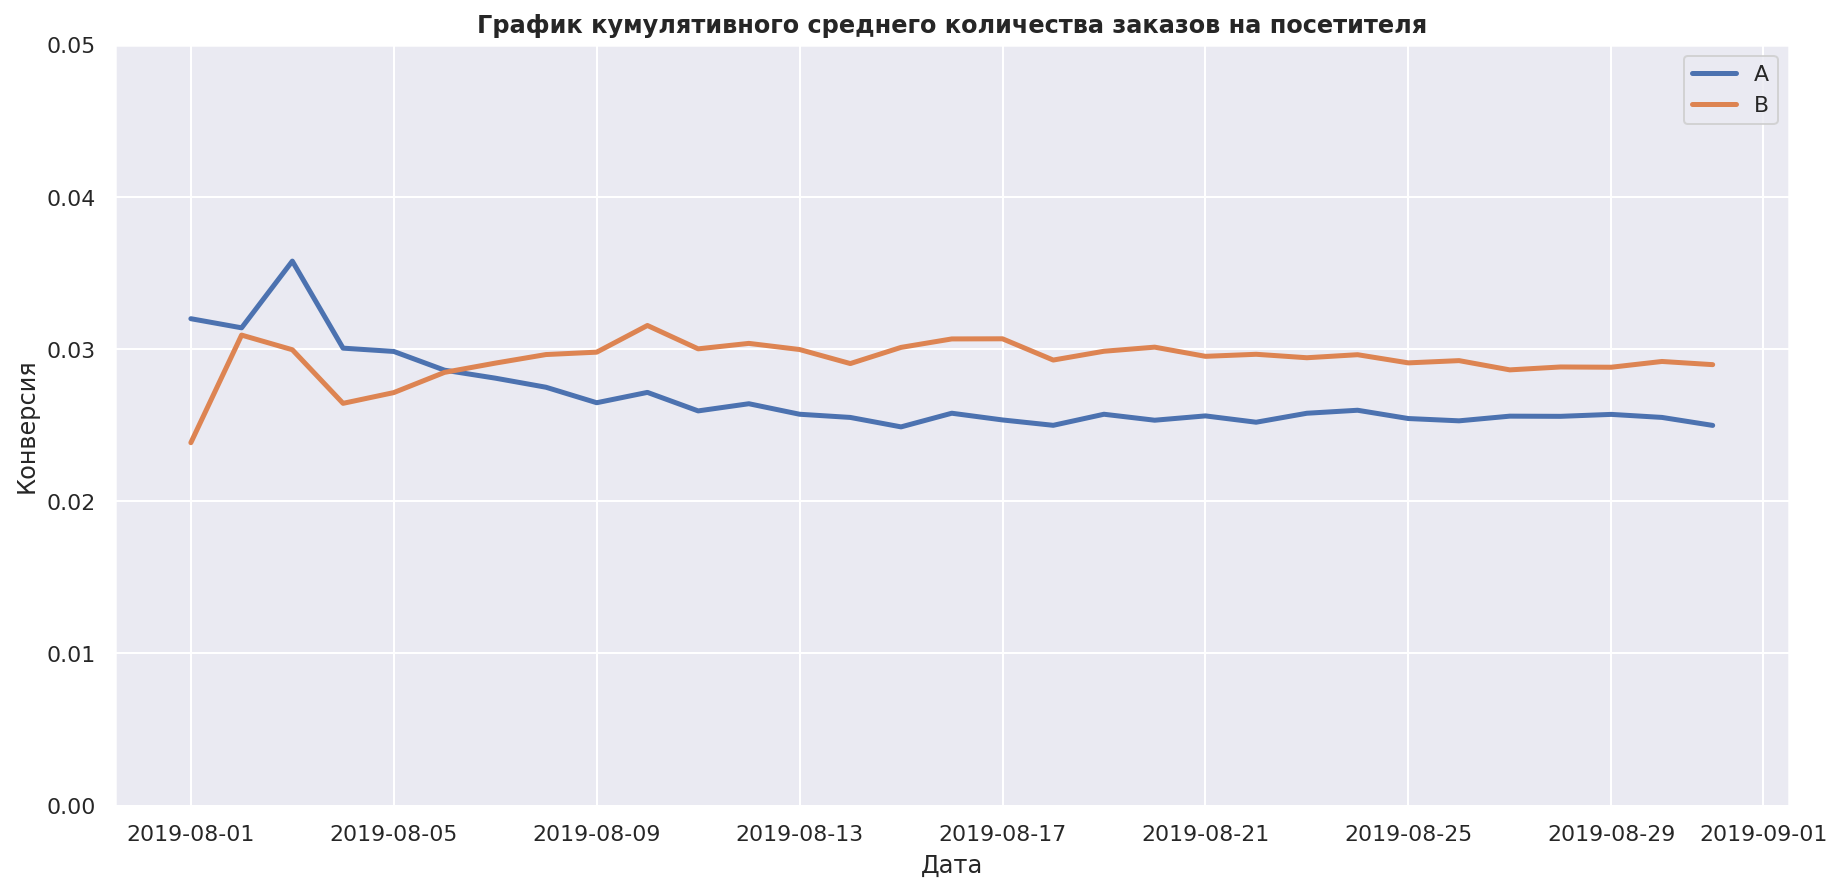

In [23]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_dataA = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_dataB = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(15, 7))
sns.lineplot(data=cumulative_dataA, x='date', y='conversion', label='A', linewidth=2.5)
sns.lineplot(data=cumulative_dataB, x='date', y='conversion', label='B', linewidth=2.5)
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивного среднего количества заказов на посетителя', fontweight="bold")
plt.ylim([0, 0.05])
plt.show()

После стабилизации графиков, конверсия группы B зафиксировалась выше, чем конверсия группы A.

**Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:**

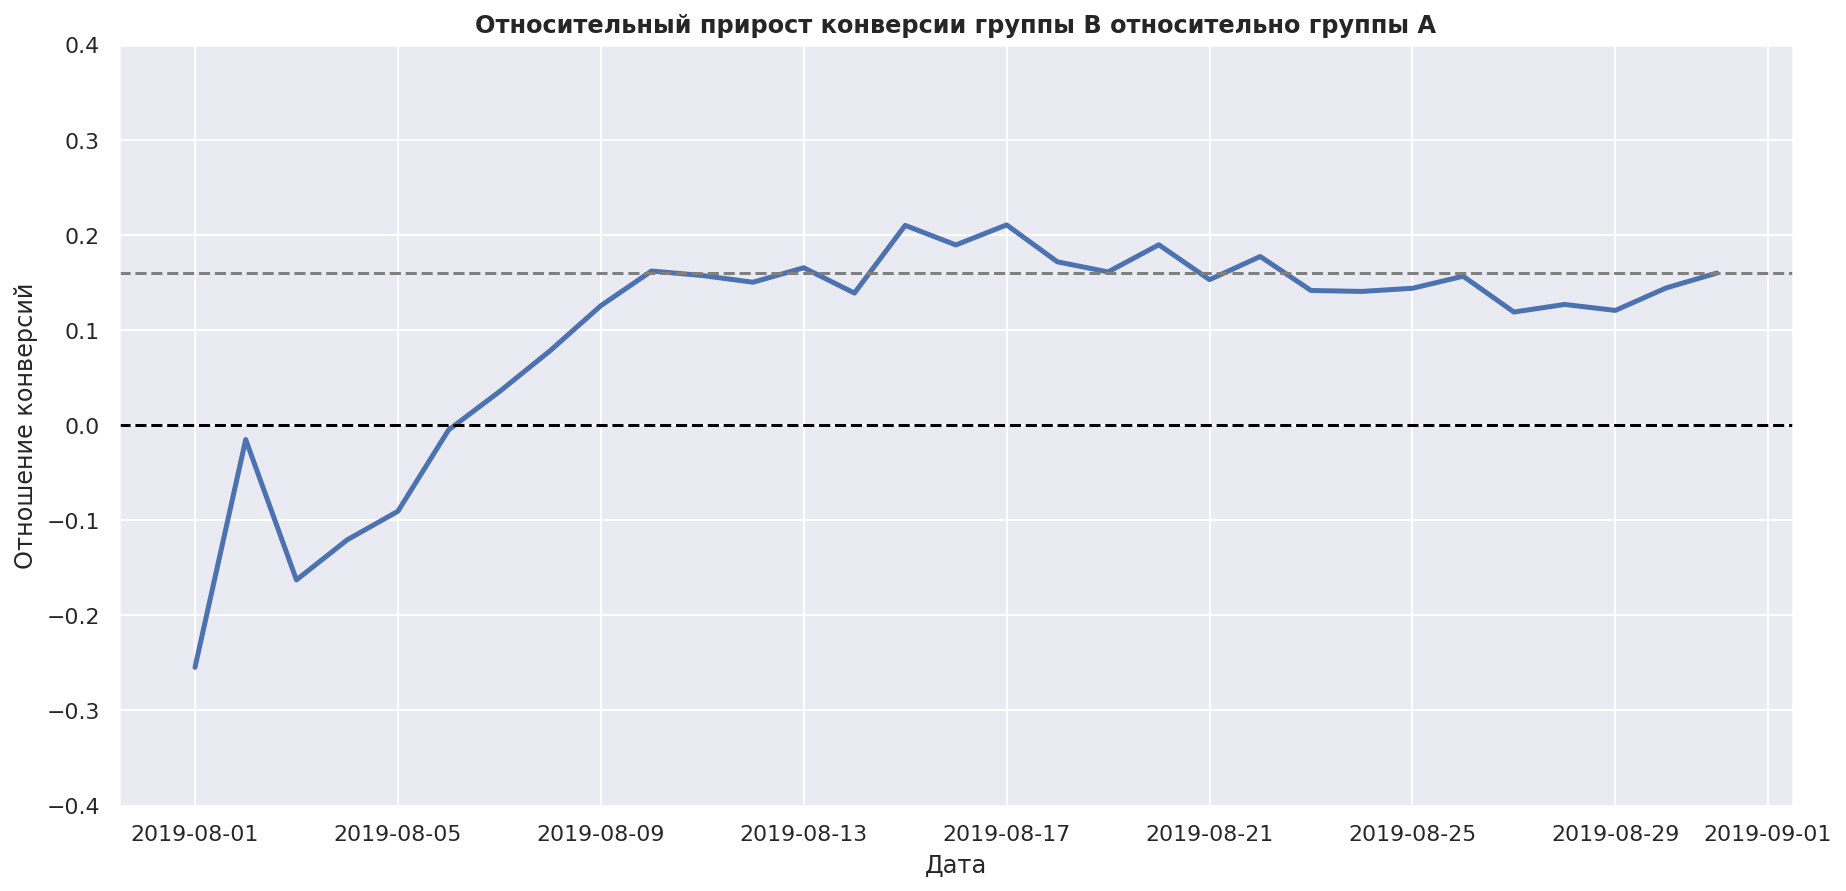

In [24]:
merged_cumulative_conversions = cumulative_dataA[['date','conversion']].merge(cumulative_dataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 7))
sns.lineplot(x=merged_cumulative_conversions['date'], y=merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, linewidth=2.5)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')
plt.ylabel('Отношение конверсий')
plt.xlabel('Дата')
plt.title('Относительный прирост конверсии группы B относительно группы A', fontweight="bold")
plt.ylim([-0.4, 0.4])
plt.show()

Наблюдаем, что отношение конверсий уже достаточно долгое время пытается установиться у одного значения (относительный прирост конверсии в группе B по отношению к группе A ~16%). Но колебания еще достаточно значительные, рано делать окончательные выводы. Проанализируем анамалии, скорее всего это их влияние.

**Построим точечный график количества заказов по пользователям:**

In [25]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique', 'group':'first'}))

orders_by_users.columns = ['visitor_id', 'orders', 'group']

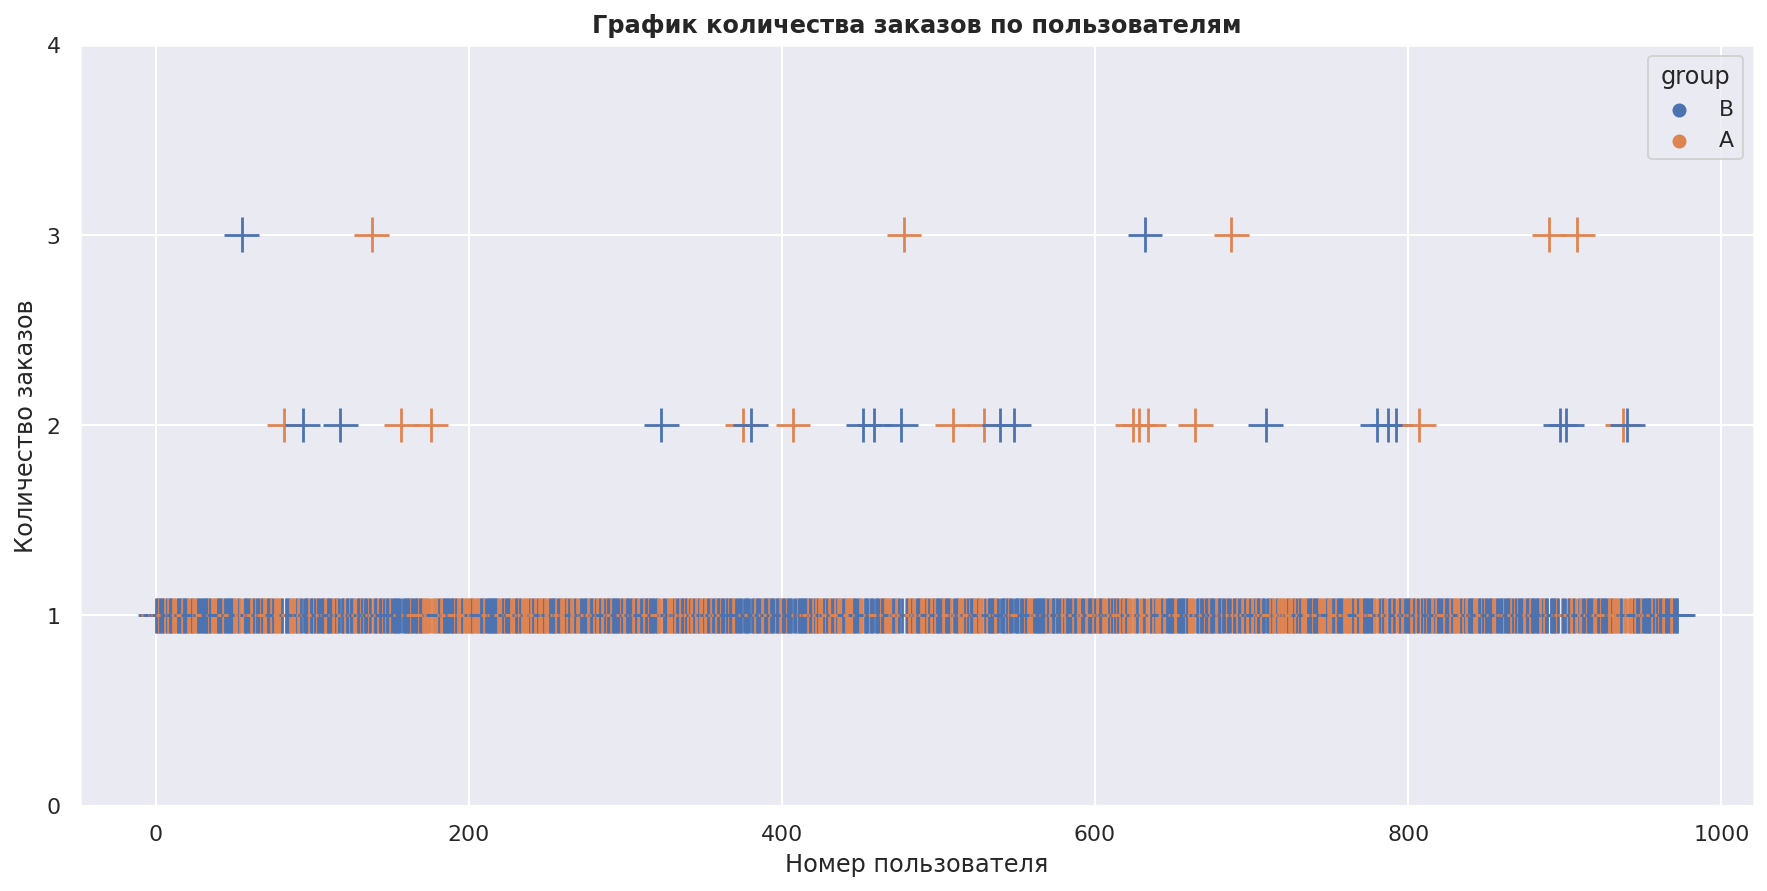

In [26]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(15,7))
sns.scatterplot(x=x_values, y=orders_by_users['orders'], hue=orders_by_users['group'], s=300, marker="+")
plt.title('График количества заказов по пользователям', fontweight="bold")
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')
plt.gca().set_yticks(np.arange(0, 5, 1))
plt.show()

В основном пользователи делали по одному заказу, некоторые по два, и совсем маленькое количество пользователей делали больше двух заказов. Кроме того, нельзя выделить, что в гакой-то из групп больше аномалий.

**Посчитаем 95-й и 99-й перцентили количества заказов на пользователя:**

In [27]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей делали больше одного заказа. Больше двух заказов делали меньше одного процента пользователей. 99-й перцентиль будет границей определения аномальных пользователей:

In [28]:
order_border = int(np.percentile(orders_by_users['orders'], [99]))

**Построим точечный график стоимостей заказов:**

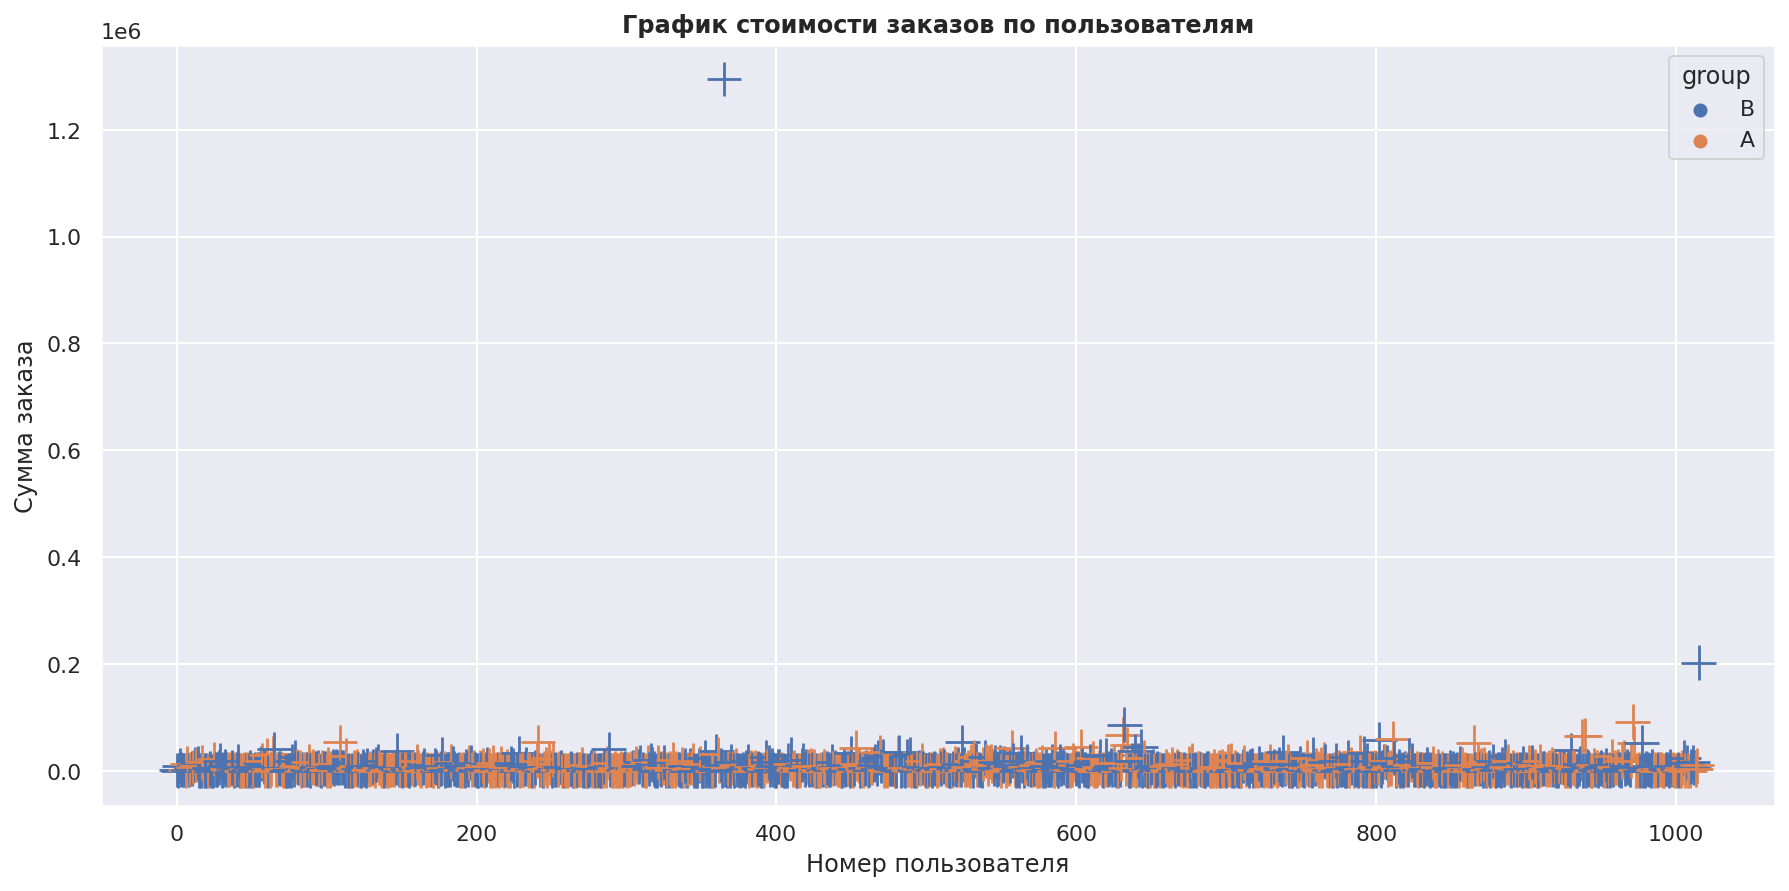

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,7))
sns.scatterplot(x=x_values, y=orders['revenue'], hue=orders['group'], s=300, marker="+")
plt.title('График стоимости заказов по пользователям', fontweight="bold")
plt.xlabel('Номер пользователя')
plt.ylabel('Сумма заказа')
plt.show()

На графике наблюдаем, что в основном заказы до 50 000 рублей. Есть выбивающиеся значения, особенно бросаются в глаза заказ на 200 000 рублей и на 1 300 000 рублей оба в группе B. Вот и причина огромного скачка на графиках.

**Посчитаем 95-й и 99-й перцентили стоимости заказов:**

In [30]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Заказы 95% пользователей были менее 26 785 рублей, менее 1% пользователей заказывали более 53 904 рублей. Выберем 99-й перцентиль границей определения аномальных пользователей:

In [31]:
revenue_border = int(np.percentile(orders['revenue'], [99]))

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным:**

```
H_0: Конверсия группы A равна конверсии группы B
H_1: Конверсия группы A не равна конверсии группы B
alpha = 0.05
```

In [32]:
visitorsA_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsA_daily.columns = ['date', 'visitors_per_dateA']

visitorsA_cummulative = visitorsA_daily.apply(
    lambda x: visitorsA_daily[visitorsA_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateA': 'sum'}
    ),
    axis=1,
)
visitorsA_cummulative.columns = ['date', 'visitors_cummulativeA']

visitorsB_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsB_daily.columns = ['date', 'visitors_per_dateB']

visitorsB_cummulative = visitorsB_daily.apply(
    lambda x: visitorsB_daily[visitorsB_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateB': 'sum'}
    ),
    axis=1,
)
visitorsB_cummulative.columns = ['date', 'visitors_cummulativeB']

ordersA_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersA_daily.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

ordersA_cummulative = ordersA_daily.apply(
    lambda x: ordersA_daily[ordersA_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateA': 'sum', 'revenue_per_dateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersA_cummulative.columns = [
    'date',
    'orders_cummulativeA',
    'revenue_cummulativeA',
]

ordersB_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersB_daily.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

ordersB_cummulative = ordersB_daily.apply(
    lambda x: ordersB_daily[ordersB_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateB': 'sum', 'revenue_per_dateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersB_cummulative.columns = [
    'date',
    'orders_cummulativeB',
    'revenue_cummulativeB',
]

data = (
    ordersA_daily.merge(
        ordersB_daily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersA_cummulative, left_on='date', right_on='date', how='left')
    .merge(ordersB_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsA_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsB_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsA_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsB_cummulative, left_on='date', right_on='date', how='left')
)

orders_by_usersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_usersA.columns = ['user_id', 'orders']

orders_by_usersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_usersB.columns = ['user_id', 'orders']

sampleA = pd.concat(
    [
        orders_by_usersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        orders_by_usersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05
print('p-value:', "{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
if st.mannwhitneyu(sampleA, sampleB)[1]<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Относительная разница между группами:', "{0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.01102
Отвергаем нулевую гипотезу
Относительная разница между группами: 16.0%


P-value = 0.01102 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 16%.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным:**

```
H_0: Различий в среднем чеке между группами нет
H_1: Есть различия в среднем чеке между группами
alpha = 0.05
```

In [33]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
alpha = 0.05
if st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Относительная разница между группами:','{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
Не получилось отвергнуть нулевую гипотезу
Относительная разница между группами: 28.7%


P-value = 0.829 значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем. Относительная разница между средними чеками групп равена 28.7%. Возможно это аномалии сильно влияют на средние. Требуется провести анализ на очищенных данных.

**Найдем и исключим аномальные данные:**

Найденные ранее 95-й и 99-й перцентили средних чеков равны 26 785 и 53 904 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 53 904 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и 1% пользователей с дорогими заказами. 

In [34]:
users_with_many_orders = pd.concat(
    [
        orders_by_usersA[orders_by_usersA['orders'] > order_border]['user_id'],
        orders_by_usersB[orders_by_usersB['orders'] > order_border]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > revenue_border]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleA_filtered = pd.concat(
    [
        orders_by_usersA[
            np.logical_not(orders_by_usersA['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB_filtered = pd.concat(
    [
        orders_by_usersB[
            np.logical_not(orders_by_usersB['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

**Построим точечный график количества заказов по пользователям без аномалий:**

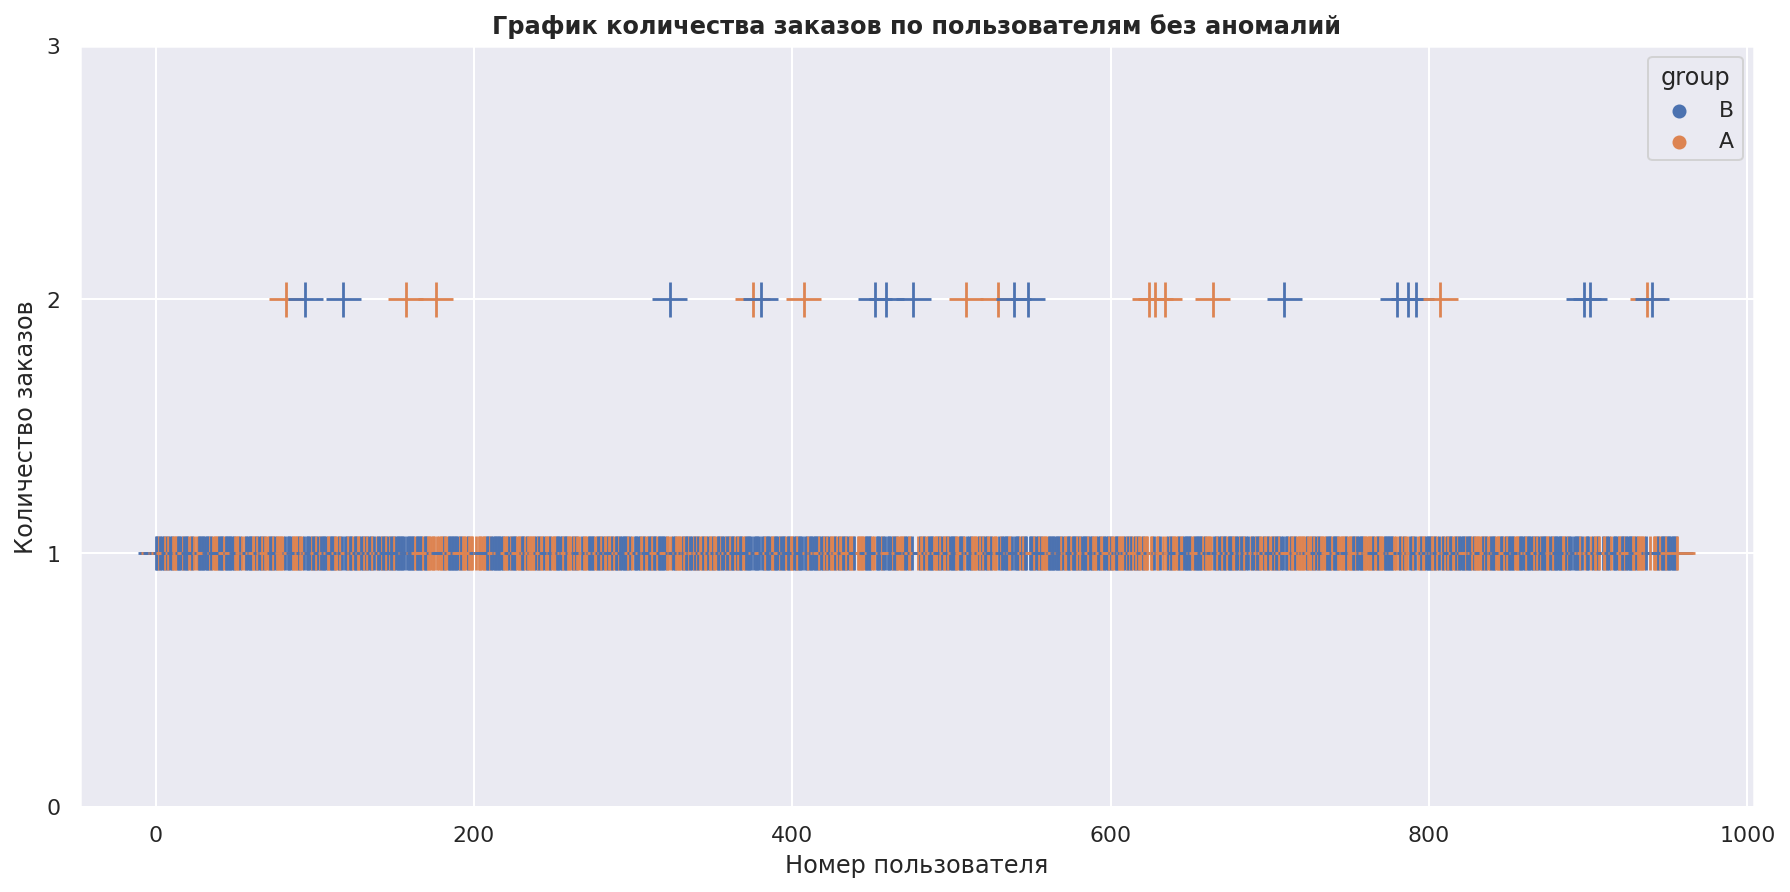

In [35]:
orders_by_norm_users = orders_by_users[np.logical_not(orders_by_users['visitor_id'].isin(abnormal_users))]
x_values = pd.Series(range(0,len(orders_by_norm_users)))

plt.figure(figsize=(15,7))
sns.scatterplot(x=x_values, y=orders_by_norm_users['orders'], hue=orders_by_norm_users['group'], s=300, marker="+")              
plt.title('График количества заказов по пользователям без аномалий', fontweight="bold")
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов')
plt.gca().set_yticks(np.arange(0, 4, 1))
plt.show()

Остались пользователи с одним и двумя заказами.

**Построим точечный график стоимости заказов по пользователям без аномалий:**

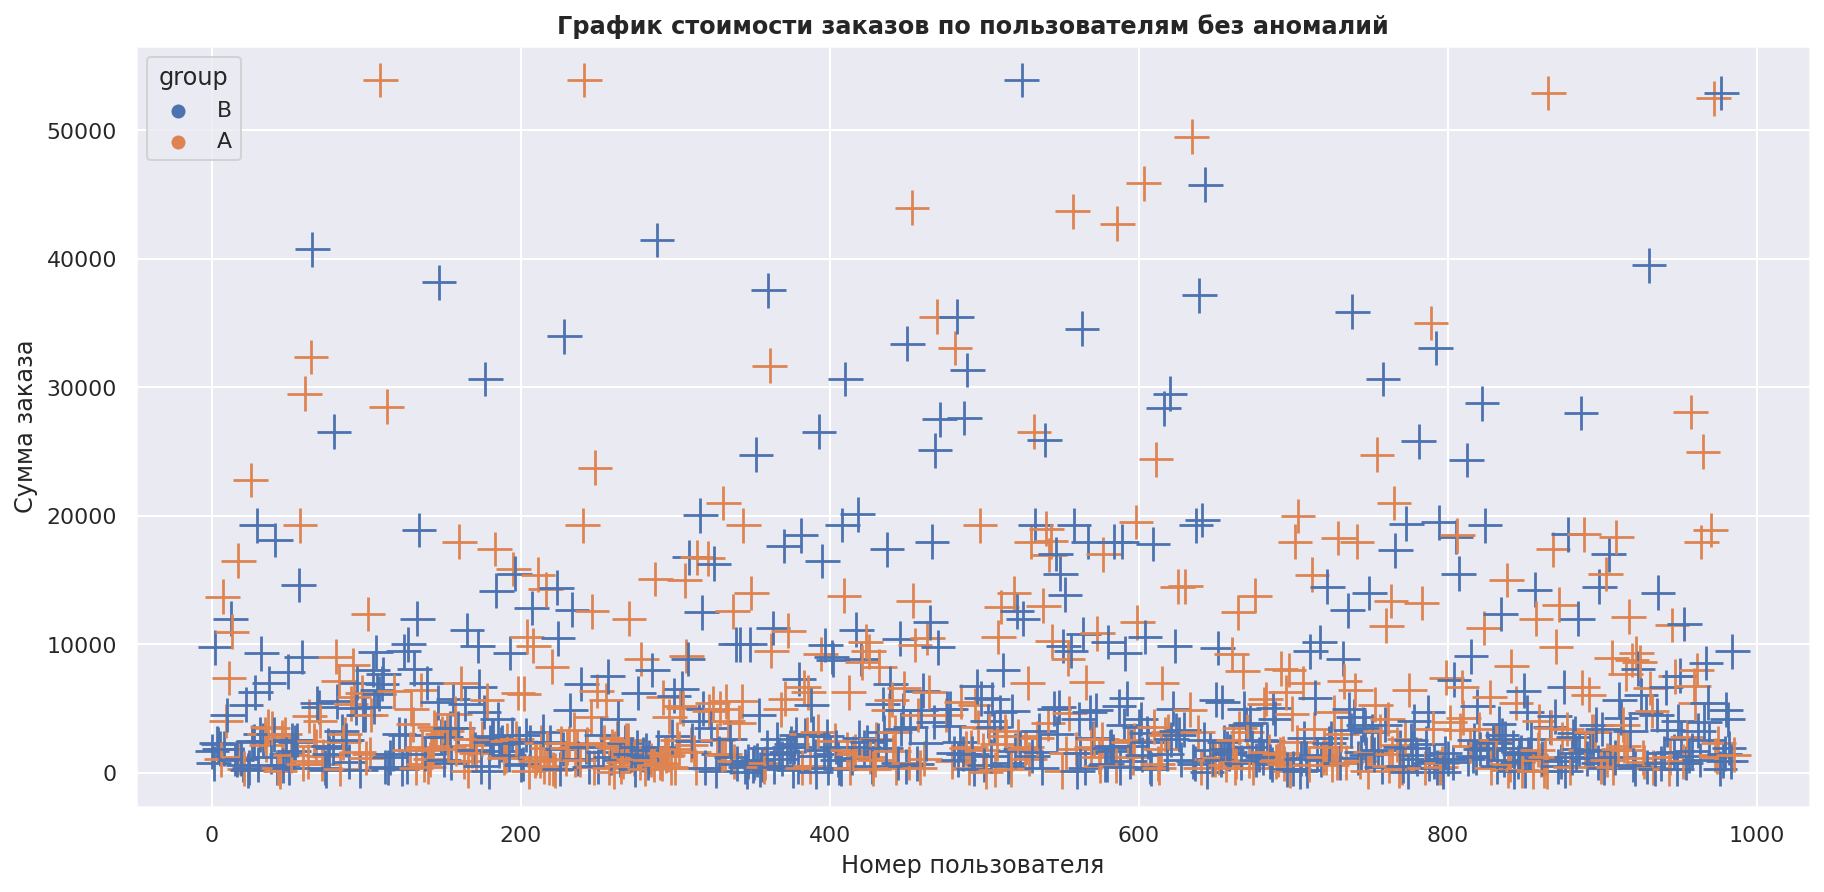

In [36]:
norm_orders = orders[np.logical_not(orders['visitor_id'].isin(abnormal_users))]
x_values = pd.Series(range(0,len(norm_orders['revenue'])))

plt.figure(figsize=(15,7))
sns.scatterplot(x=x_values, y=norm_orders['revenue'], hue=norm_orders['group'], s=300, marker="+")
plt.title('График стоимости заказов по пользователям без аномалий', fontweight="bold")
plt.xlabel('Номер пользователя')
plt.ylabel('Сумма заказа')
plt.show()

Полулилочь удалить аномальные значения. Притом, что мы выбрали 99 перцентиль как границу, оставшиеся крупные заказы не выглядят аномальными, скорее просто редкими. 

**Посчитем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным:**

```
H_0: Конверсия группы A равна конверсии группы B
H_1: Конверсия группы A не равна конверсии группы B
alpha = 0.05
```

In [37]:
alpha = 0.05
print('p-value:', "{0:.5f}".format(st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
if st.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Относительная разница между группами:', "{0:.1%}".format(sampleB_filtered.mean() / sampleA_filtered.mean() - 1))

p-value: 0.00702
Отвергаем нулевую гипотезу
Относительная разница между группами: 18.9%


Как и в случае с "грязными" данными статическая значимость достигнута (p-value: 0.00702). Конверсия у группы B выше, чем у группы A. Относительная разница между средним количеством заказов групп 18.9%.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным:**

```
H_0: Различий в среднем чеке между группами нет
H_1: Есть различия в среднем чеке между группами
alpha = 0.05
```

In [38]:
print('p-value:', 
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

if st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Относительная разница между группами:', 
    "{0:.1%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 


p-value: 0.788
Не получилось отвергнуть нулевую гипотезу
Относительная разница между группами: -3.2%


Как и в случае с "грязными" данными не получилось отвергнуть нулевую гипотезу. Однако исключив аномалии наблюдаем, что действительно разница между средними чеками двух групп незначительна и составляет 3.2%.

### Общий вывод

В ходе проверки данных удалось выяснить, что данные отправляются в системы аналитики некорректно. Около 6% пользователей попали в и в группу A, и в группу B. Этих пользователей удалось исключить из таблицы orders, но не удалось исключить из таблицы visitors.


Далее, построив графики, удалось визуализировать выбросы и аномалии. Кроме того, графики помогли нам понять, что достаточно исключить по 1% аномальных пользователей по количеству и стоимости заказов, так как количество аномалий небольшое, но они достаточно серьезно влияют результаты (чего только стоит заказ на 1 300 000 рублей). Таким образом, удалось очистить данные от аномалий и сохранить наибольшее количество данных.


По результатом статистических тестов: 
- конверсия у группы B не равна конверсии группы A. P-value: 0.007, т.е. вероятность ошибки менее 1%. Средним количество заказов в группе B на 18.9% выше, чем в группе A; 
- нет статистически значимого различия по среднему чеку между группами (p-value: 0.788). Относительная разница между средними чеками двух групп незначительна и составляет 3.2%.

Таким образом, с учетом допущенных ошибок при проведении теста, можно сделать вывод, что результаты в группе B значительно лучше, чем в группе A и перекрывает возможную погрешность. Тест можно завершить, признать его успешным. Перед проведением следующего теста требуется проверить инструмент «деления» трафика и как данные отправляются в системы аналитики. 